<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/%EB%8C%80%ED%9A%8C_for_%EB%93%9C%EB%A1%A0A_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

zip_path = "/content/ICSV31AIChallengeDataset.zip"  # 업로드한 ZIP 파일 경로
extract_path = "/content/ICSV31AIChallengeDataset"  # 압축을 풀 폴더 경로

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)


압축 해제 완료: /content/ICSV31AIChallengeDataset


Epoch 1, Loss: 0.184770
Epoch 2, Loss: 0.085808
Epoch 3, Loss: 0.068293
Epoch 4, Loss: 0.059947
Epoch 5, Loss: 0.053938
Epoch 6, Loss: 0.050199
Epoch 7, Loss: 0.048031
Epoch 8, Loss: 0.045863
Epoch 9, Loss: 0.044213
Epoch 10, Loss: 0.042958


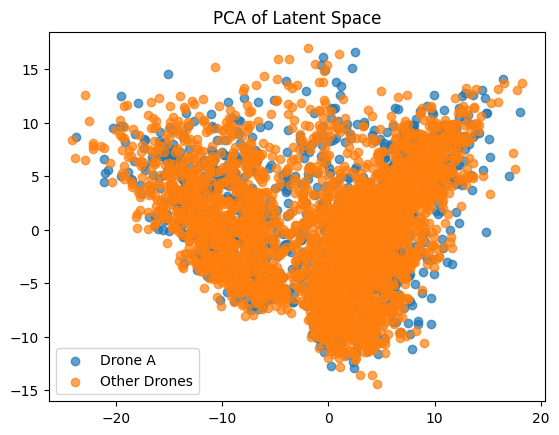

kNN Accuracy: 0.7229629629629629
SVM Accuracy: 0.7288888888888889


In [ ]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# AutoEncoder 모델 (Latent Vector 추출 가능하도록)
class WaveNetAutoencoder(nn.Module):
    def __init__(self, input_channels, latent_dim=16):  # Latent Space 크기 설정
        super(WaveNetAutoencoder, self).__init__()

        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, latent_dim, kernel_size=3, padding=1)  # Latent Space
        )

        # 디코더
        self.decoder = nn.Sequential(
            nn.Conv1d(latent_dim, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, input_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded  # Latent Vector & 복원 데이터 반환

# 데이터 전처리
def extract_features(file_path, sr=16000, n_mels=64):
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # 정규화 (z-score)
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)
    log_mel_spec = (log_mel_spec - mean) / (std + 1e-6)

    return log_mel_spec[np.newaxis, :, :]

# 드론 유형(A, B, C) 추출하는 함수
def get_drone_type(file_name):
    match = re.search(r'train_(A|B|C)_', file_name)  # 정규 표현식으로 드론 타입 추출
    if match:
        return match.group(1)  # A, B, C 중 하나 반환
    return None  # 일치하는 드론 유형이 없으면 None 반환

# 드론 A 데이터와 다른 드론 데이터 분리
def load_audio_data(folder_path, target_drone="A"):
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    drone_A_files = [f for f in files if get_drone_type(f) == target_drone]
    other_drone_files = [f for f in files if get_drone_type(f) != target_drone]

    drone_A_data = np.array([extract_features(os.path.join(folder_path, f)) for f in drone_A_files], dtype=np.float32)
    other_drone_data = np.array([extract_features(os.path.join(folder_path, f)) for f in other_drone_files], dtype=np.float32)

    return drone_A_data, other_drone_data

def create_dataloader(data, batch_size=32):
    tensor_data = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Latent Vector 추출 함수
def extract_latent_vectors(model, data_loader):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0].to(device).squeeze(1)
            encoded, _ = model(inputs)  # Latent Vector 추출
            latent_vectors.append(encoded.cpu().numpy())

    return np.concatenate(latent_vectors, axis=0).reshape(len(data_loader.dataset), -1)

# 모델 학습 및 Latent Vector 추출
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "/content/ICSV31AIChallengeDataset/train"

# 드론 A와 다른 드론 데이터 로드
train_data_A, train_data_other = load_audio_data(train_dir, target_drone="A")

# A 드론은 1, 다른 드론은 0으로 라벨링
labels_A = np.ones(len(train_data_A))
labels_other = np.zeros(len(train_data_other))

# 데이터 합치기
train_data = np.vstack([train_data_A, train_data_other])
train_labels = np.hstack([labels_A, labels_other])

train_loader = create_dataloader(train_data)

# 모델 정의 및 학습
input_channels = train_data.shape[2]  # train_data.shape[2]을 사용하여 채널 수를 가져옵니다.
model = WaveNetAutoencoder(input_channels, latent_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# AutoEncoder 학습
for epoch in range(10):
    model.train()
    total_loss = 0
    for inputs in train_loader:
        inputs = inputs[0].to(device).squeeze(1)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.6f}")

# Latent Vector 추출 및 PCA 분석
latent_vectors = extract_latent_vectors(model, train_loader)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.scatter(latent_2d[train_labels == 1, 0], latent_2d[train_labels == 1, 1], label="Drone A", alpha=0.7)
plt.scatter(latent_2d[train_labels == 0, 0], latent_2d[train_labels == 0, 1], label="Other Drones", alpha=0.7)
plt.legend()
plt.title("PCA of Latent Space")
plt.show()

# kNN/SVM을 이용한 드론 A 분류
X_train, y_train = latent_vectors, train_labels

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

print("kNN Accuracy:", accuracy_score(y_train, knn.predict(X_train)))
print("SVM Accuracy:", accuracy_score(y_train, svm.predict(X_train)))

Epoch 1, Loss: 0.299529
Epoch 2, Loss: 0.248420
Epoch 3, Loss: 0.242575
Epoch 4, Loss: 0.239206
Epoch 5, Loss: 0.236708
Epoch 6, Loss: 0.234668
Epoch 7, Loss: 0.233569
Epoch 8, Loss: 0.232352
Epoch 9, Loss: 0.231036
Epoch 10, Loss: 0.230163
Epoch 11, Loss: 0.229312
Epoch 12, Loss: 0.228534
Epoch 13, Loss: 0.227585
Epoch 14, Loss: 0.226999
Epoch 15, Loss: 0.226488
Epoch 16, Loss: 0.225631
Epoch 17, Loss: 0.224875
Epoch 18, Loss: 0.224363
Epoch 19, Loss: 0.223993
Epoch 20, Loss: 0.223598
Epoch 21, Loss: 0.223351
Epoch 22, Loss: 0.223085
Epoch 23, Loss: 0.222697
Epoch 24, Loss: 0.222858
Epoch 25, Loss: 0.222471
Epoch 26, Loss: 0.222217
Epoch 27, Loss: 0.221913
Epoch 28, Loss: 0.221583
Epoch 29, Loss: 0.221579
Epoch 30, Loss: 0.221257
Epoch 31, Loss: 0.221273
Epoch 32, Loss: 0.220756
Epoch 33, Loss: 0.221263
Epoch 34, Loss: 0.220613
Epoch 35, Loss: 0.220715
Epoch 36, Loss: 0.220550
Epoch 37, Loss: 0.220614
Epoch 38, Loss: 0.220247
Epoch 39, Loss: 0.220266
Epoch 40, Loss: 0.220221
Epoch 41,

<ipython-input-5-7d1622076e6e>:175: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


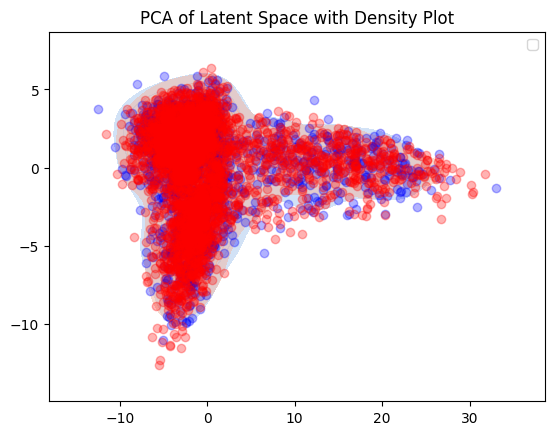

kNN Accuracy (Cross-Validation): 0.5987
SVM Accuracy (Cross-Validation): 0.5717


In [ ]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

# -------------------------------
# AutoEncoder 모델 정의 (Latent Vector 추출 가능)
# -------------------------------
class WaveNetAutoencoder(nn.Module):
    def __init__(self, input_channels, latent_dim=16):
        super(WaveNetAutoencoder, self).__init__()

        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, latent_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )

        # 디코더
        self.decoder = nn.Sequential(
            nn.Conv1d(latent_dim, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, input_channels, kernel_size=3, padding=1),
            nn.Tanh()  # 출력값 안정화
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# -------------------------------
# 데이터 전처리 함수
# -------------------------------
def extract_features(file_path, sr=16000, n_mels=64):
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # 정규화 (z-score)
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)
    log_mel_spec = (log_mel_spec - mean) / (std + 1e-6)

    return log_mel_spec[np.newaxis, :, :]

# 드론 유형(A, B, C) 추출
def get_drone_type(file_name):
    match = re.search(r'train_(A|B|C)_', file_name)
    return match.group(1) if match else None

# 데이터 로드 (병렬 처리 적용)
def load_audio_data(folder_path, target_drone="A", n_jobs=-1):
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    drone_A_files = [f for f in files if get_drone_type(f) == target_drone]
    other_drone_files = [f for f in files if get_drone_type(f) != target_drone]

    drone_A_data = Parallel(n_jobs=n_jobs)(delayed(extract_features)(os.path.join(folder_path, f)) for f in drone_A_files)
    other_drone_data = Parallel(n_jobs=n_jobs)(delayed(extract_features)(os.path.join(folder_path, f)) for f in other_drone_files)

    return np.array(drone_A_data, dtype=np.float32), np.array(other_drone_data, dtype=np.float32)

# DataLoader 생성
def create_dataloader(data, batch_size=32):
    tensor_data = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# Latent Vector 추출 함수
# -------------------------------
def extract_latent_vectors(model, data_loader):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0].to(device).squeeze(1)
            encoded, _ = model(inputs)
            latent_vectors.append(encoded.cpu().numpy())

    return np.concatenate(latent_vectors, axis=0).reshape(len(data_loader.dataset), -1)

# -------------------------------
# 모델 학습 및 Latent Vector 추출
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "/content/ICSV31AIChallengeDataset/train"

# 드론 A와 다른 드론 데이터 로드
train_data_A, train_data_other = load_audio_data(train_dir, target_drone="A")

# A 드론은 1, 다른 드론은 0으로 라벨링
labels_A = np.ones(len(train_data_A))
labels_other = np.zeros(len(train_data_other))

# 데이터 병합
train_data = np.vstack([train_data_A, train_data_other])
train_labels = np.hstack([labels_A, labels_other])

train_loader = create_dataloader(train_data)

# 모델 정의 및 학습
input_channels = train_data.shape[2]
model = WaveNetAutoencoder(input_channels, latent_dim=16).to(device)  # latent_dim 바꿔가면서 실험
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Early Stopping 설정
best_loss = float('inf')
patience = 3
wait = 0

for epoch in range(100):  # 최대 100 에포크
    model.train()
    total_loss = 0
    for inputs in train_loader:
        inputs = inputs[0].to(device).squeeze(1)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

    # Early Stopping 체크
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early Stopping Activated!")
            break

# -------------------------------
# Latent Vector 분석 (PCA)
# -------------------------------
latent_vectors = extract_latent_vectors(model, train_loader)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

sns.kdeplot(x=latent_2d[train_labels == 1, 0], y=latent_2d[train_labels == 1, 1], fill=True, alpha=0.5, label="Drone A")
sns.kdeplot(x=latent_2d[train_labels == 0, 0], y=latent_2d[train_labels == 0, 1], fill=True, alpha=0.5, label="Other Drones")
plt.scatter(latent_2d[train_labels == 1, 0], latent_2d[train_labels == 1, 1], alpha=0.3, color='blue')
plt.scatter(latent_2d[train_labels == 0, 0], latent_2d[train_labels == 0, 1], alpha=0.3, color='red')
plt.legend()
plt.title("PCA of Latent Space with Density Plot")
plt.show()

📌 드론 A 평균 좌표: [0.02773181 0.07023753], 분산: [42.55027   8.602611]
📌 다른 드론 평균 좌표: [-0.01386882 -0.0351131 ], 분산: [39.931137  9.064468]
 클래스 간 중심 거리 (Euclidean Distance): 0.1133
T-test 결과: t-statistic=[0.22555774 1.222351  ], p-value=[0.82155395 0.22162831]


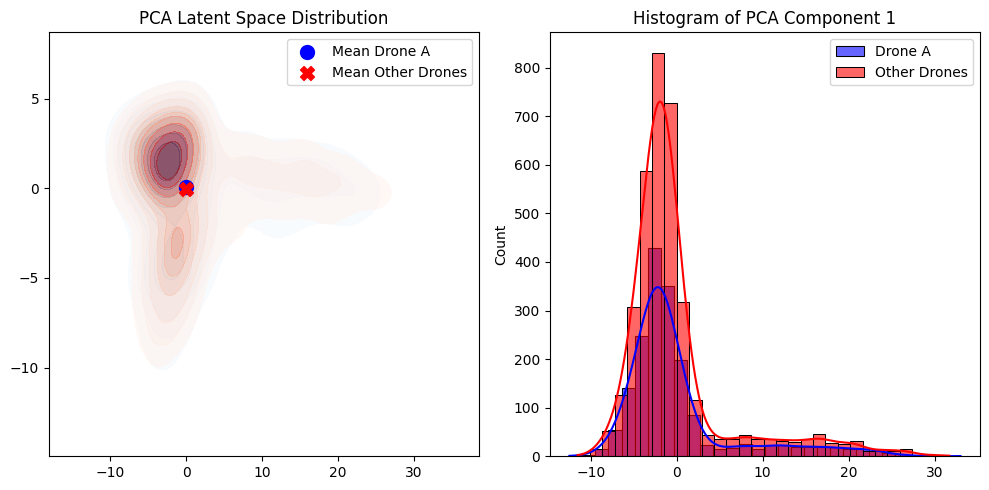

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_ind

# 드론 A와 다른 드론의 PCA 변환된 값 분리
latent_A = latent_2d[train_labels == 1]
latent_other = latent_2d[train_labels == 0]

# 1. 평균 및 분산 비교
mean_A, var_A = np.mean(latent_A, axis=0), np.var(latent_A, axis=0)
mean_other, var_other = np.mean(latent_other, axis=0), np.var(latent_other, axis=0)

print(f"📌 드론 A 평균 좌표: {mean_A}, 분산: {var_A}")
print(f"📌 다른 드론 평균 좌표: {mean_other}, 분산: {var_other}")

# 2. 두 클래스 간 중심 거리 (Euclidean Distance)
center_distance = euclidean(mean_A, mean_other)
print(f" 클래스 간 중심 거리 (Euclidean Distance): {center_distance:.4f}")

# 3. 분포 차이를 통계적으로 검증 (t-test)
t_stat, p_value = ttest_ind(latent_A, latent_other)
print(f"T-test 결과: t-statistic={t_stat}, p-value={p_value}")

# 4. 시각화 (KDE Plot & 히스토그램)
plt.figure(figsize=(10, 5))

# KDE Plot
plt.subplot(1, 2, 1)
# x와 y 키워드 인수를 사용하여 두 변수의 관계를 시각화
sns.kdeplot(x=latent_A[:, 0], y=latent_A[:, 1], cmap="Blues", fill=True, alpha=0.5, label="Drone A")
sns.kdeplot(x=latent_other[:, 0], y=latent_other[:, 1], cmap="Reds", fill=True, alpha=0.5, label="Other Drones")
plt.scatter(mean_A[0], mean_A[1], color="blue", marker="o", s=100, label="Mean Drone A")
plt.scatter(mean_other[0], mean_other[1], color="red", marker="X", s=100, label="Mean Other Drones")
plt.legend()
plt.title("PCA Latent Space Distribution")

# 히스토그램 (첫 번째 주성분)
plt.subplot(1, 2, 2)
sns.histplot(latent_A[:, 0], bins=30, color='blue', alpha=0.6, label="Drone A", kde=True)
sns.histplot(latent_other[:, 0], bins=30, color='red', alpha=0.6, label="Other Drones", kde=True)
plt.legend()
plt.title("Histogram of PCA Component 1")

plt.tight_layout()
plt.show()